### Games analysis

This notebook was used to get a feel of the data and it creates a quick visualization of some baragining sequences.

This is not used for the final paper

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cycler
from matplotlib.ticker import MultipleLocator, FormatStrFormatter,AutoMinorLocator
from multiprocessing import Pool, Lock
import sys
from game import Game

In [ ]:
Here we load the data from http://data.nber.org/data/bargaining/

The date column is saved as a string and caused some problems, hence we convert it and save it to a new csv file to save time.

In [ ]:
data = pd.read_csv("data/anon_bo_threads.csv",sep=',',usecols=['anon_item_id', 'anon_thread_id', 'anon_byr_id', 'anon_slr_id', 'offr_type_id', 'status_id', 'offr_price', 'src_cre_date'], converters={'src_cre_date':pd.Timestamp})
data.to_csv('data/anon_bo_threads_dates_converted.csv')

In [2]:
data = pd.read_csv("data/anon_bo_threads_dates_converted.csv",sep=',',usecols=['anon_item_id', 'anon_thread_id', 'anon_byr_id', 'anon_slr_id', 'offr_type_id', 'status_id', 'offr_price', 'src_cre_date'])

We remove all the offers that received no response

In [3]:
data = data[data['status_id'] != 0]

We take the numbers of elements in each separate game. This is done by taking all the offers for a specific item.

In [4]:
multiplicity = data.groupby('anon_item_id').count()['anon_byr_id']

In [5]:
def create_games(index, cur, df, output):
    output[cur] = Game(game=df.loc[df['anon_item_id'] == index])

v_create_games = np.vectorize(create_games, excluded=['df', 'output'], cache=True)

We create a maximum of NUM_GAMES games that have a number of turns between FIRST and LAST.

In [6]:
FIRST = 8
LAST = 12
NUM_GAMES = 100 #9000 for plots
games = np.empty((LAST - FIRST,NUM_GAMES), dtype=list)
for j in range(FIRST,LAST):
    sys.stdout.write("\rProgress: " + str(round((j-FIRST) * 100 / (LAST - FIRST - 1),2)) + "%")
    multiplicity_spliced = np.array(multiplicity[multiplicity == j][:NUM_GAMES].index)
    v_create_games(index=multiplicity_spliced, cur=range(NUM_GAMES), df=data, output=games[j-FIRST])

Progress: 100.0%

Here we plot every turn of the game in a separate figure.

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


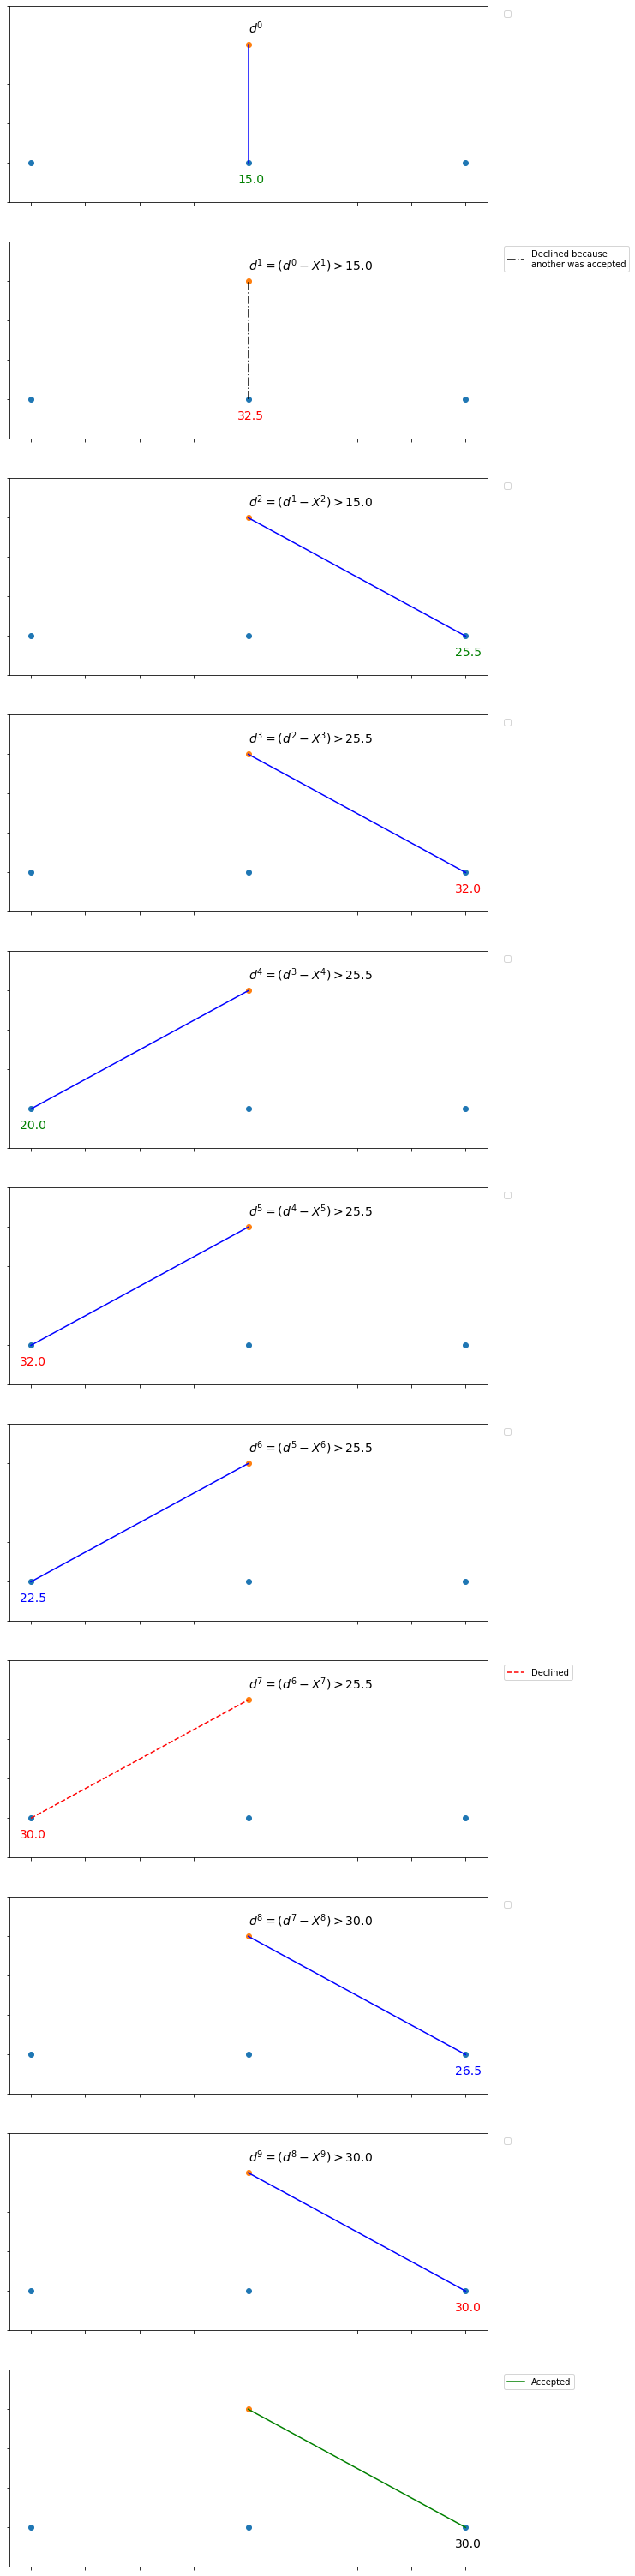

In [7]:
game_to_plot = games[2][15]

offers = game_to_plot.get_offers().replace(to_replace=game_to_plot.id_map)

n_rows = len(offers) + 1 if game_to_plot.sold() else len(offers)

fig, axes = plt.subplots(nrows=n_rows, ncols=1, figsize=(10,n_rows * 5))
d_seller = 0
#g initial offer, b buyer counteroffer, r seller counteroffer
colors = ['g','b','r']
i = 0
d_seller_label = '$d^0$'
for offer, ax in zip(offers.iterrows(), axes):
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    #ax.axis('off')
    color_line = 'b'
    line_type = '-'
    label = ""
    if offer[1]['status_id'] == 6:
        color_line = 'r'
        label = "Auto declined"
    if offer[1]['status_id'] == 2:
        color_line = 'r'
        line_type = '--'
        label = "Declined"
    if (offer[1]['status_id'] == 0):
        color_line = 'black'
        label = "Offer expired"
    elif (offer[1]['status_id'] == 8):
        color_line = 'black'
        line_type = '-.'
        label = "Declined because \nanother was accepted"
    ax.plot([offer[1]['anon_byr_id'], game_to_plot.get_seller_normalized()],[1, 4], line_type, color=color_line, label=label)
    ax.scatter(game_to_plot.get_buyers_normalized(), [1] * game_to_plot.get_n_buyers())
    ax.scatter(game_to_plot.get_seller_normalized(), [4])
    if (offer[1]['offr_price'] > d_seller) & ((offer[1]['status_id'] == 6) | (offer[1]['status_id'] == 2) | ((offer[1]['status_id'] == 7) & (offer[1]['offr_type_id'] != 2))):
        d_seller = offer[1]['offr_price']
    ax.text(offer[1]['anon_byr_id']-0.05, 0.5, str(offer[1]['offr_price']), fontsize=14, color=colors[offer[1]['offr_type_id']])
    ax.text(game_to_plot.get_seller_normalized(), 4.3, d_seller_label, fontsize=14)
    ax.set_ylim([0, 5])
    i = i + 1
    d_seller_label = '$d^{{{}}} = (d^{{{}}} - X^{{{}}})> {}$'.format(i,i-1,i, d_seller if d_seller != 0 else '?')
    ax.legend(bbox_to_anchor=(1.025, 1), loc='upper left')

if game_to_plot.sold():
    axes[-1].set_xticklabels([])
    axes[-1].set_yticklabels([])
    axes[-1].scatter(game_to_plot.get_buyers_normalized(), [1] * game_to_plot.get_n_buyers())
    axes[-1].scatter(game_to_plot.get_seller_normalized(), [4])
    axes[-1].plot([game_to_plot.get_winner(), game_to_plot.get_seller_normalized()],[1, 4], 'g', label = "Accepted")
    axes[-1].text(game_to_plot.get_winner()-0.05, 0.5, str(game_to_plot.get_winner_offer()), fontsize=14, color='black')
    axes[-1].set_ylim([0, 5])
    axes[-1].legend(bbox_to_anchor=(1.025, 1), loc='upper left')

ax.grid(False)

## Trend analysis on games

In this section we analyse the trends that are present when considering the game as a whole instead of a sequence of individual offers.

In [8]:
num_turns = 10
matrix_seller = [[]] * (num_turns + 2)
matrix_buyer = [[]] * (num_turns + 2)
buyer_dict = {}
for i in range(NUM_GAMES):
    offers = games[num_turns - FIRST][i].get_offers()
    assert(len(offers) == num_turns)
    seller_offer_counter = 0
    last_offer = -1
    for offer in offers.iterrows():
        if offer[1]['offr_type_id'] == 2:
            arr = matrix_seller[seller_offer_counter]
            if last_offer == -1:
                last_offer = offer[1]['offr_price']
                new_arr = arr + [offer[1]['offr_price']]
            else:
                new_arr = arr + [offer[1]['offr_price'] - last_offer]
                last_offer = offer[1]['offr_price']
            matrix_seller[seller_offer_counter] = new_arr
            seller_offer_counter = seller_offer_counter + 1
        else:
            buyer_id = offer[1]['anon_byr_id']
            check = buyer_dict.get((buyer_id,i), -1)
            if check == -1:
                buyer_dict[(buyer_id,i)] = []
                
            last = 0 if len(buyer_dict[(buyer_id,i)]) == 0 else buyer_dict[(buyer_id,i)][-1]
            temp = matrix_buyer[len(buyer_dict[(buyer_id,i)])]
            new_arr = temp + [offer[1]['offr_price'] - last]
            matrix_buyer[len(buyer_dict[(buyer_id,i)])] = new_arr
            test_len = len(buyer_dict[(buyer_id,i)])
            buyer_dict[(buyer_id,i)] = buyer_dict[(buyer_id,i)] + [offer[1]['offr_price']]
            assert(len(buyer_dict[(buyer_id,i)]) == test_len + 1)

In [9]:
seller_trend = []
buyer_trend = []
last = 0
for seller in matrix_seller[1:]:
    temp = np.mean(seller)
    seller_trend.append(temp + last)
    last = temp + last

last = 0
for buyer in matrix_buyer[1:]:
    temp = np.mean(buyer)
    buyer_trend.append(temp + last)
    last = temp + last

In [10]:
def plot_setup():
    plt.rcParams.update({'font.size': 10})
    colors = cycler('color',
                    [ '#2F4F4F', '#EE6666', '#3388BB', '#9988DD',
                     '#EECC55', '#88BB44', '#FFBBBB'])
    plt.rc('axes', facecolor='#E6E6E6', edgecolor='none',
           axisbelow=True, prop_cycle=colors)
    plt.rc('grid', color='w', linestyle='solid', linewidth=3)
    plt.rc('xtick', direction='out', color='black')
    plt.rc('ytick', direction='out', color='black')
    plt.rc('patch', edgecolor='#E6E6E6')
    plt.rc('lines', linewidth=2)

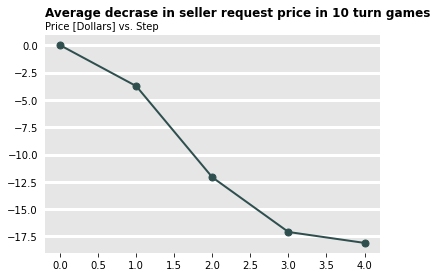

In [11]:
plot_setup()

plt.plot(range(len(seller_trend) + 1), [0] + seller_trend, '.-', markersize=14)

plt.gcf().text(0.125, 0.9,"Price [Dollars] vs. Step", fontsize=10)
title = "Average decrase in seller request price in " + str(num_turns) + " turn games"
plt.title(title, loc='left', y=1.06, fontsize=12, weight='bold')

ax = plt.gca()
ax.grid(which='major', axis='y')
plt.yticks(fontsize=10)
plt.axes().tick_params(left=False)
plt.xticks(fontsize=10, rotation=0)
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=True,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=True)  # labels along the bottom edge are off

plt.rcParams["figure.figsize"]  = [7, 4.8]
plt.show()

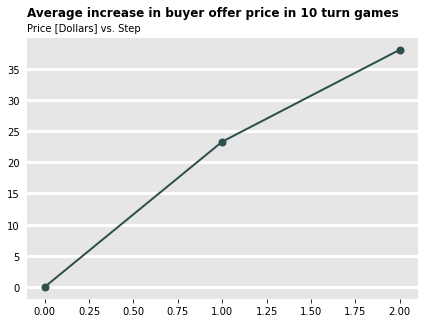

In [12]:
plot_setup()

plt.plot(range(len(buyer_trend) + 1), [0] + buyer_trend, '.-', markersize=14)

plt.gcf().text(0.125, 0.9,"Price [Dollars] vs. Step", fontsize=10)
title = "Average increase in buyer offer price in " + str(num_turns) + " turn games"
plt.title(title, loc='left', y=1.06, fontsize=12, weight='bold')

ax = plt.gca()
ax.grid(which='major', axis='y')
plt.yticks(fontsize=10)
plt.axes().tick_params(left=False)
plt.xticks(fontsize=10, rotation=0)
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=True,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=True)  # labels along the bottom edge are off

plt.rcParams["figure.figsize"]  = [7, 4.8]
plt.show()